In [1]:
# Basic imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sentence_transformers import SentenceTransformer


## Loading Libraries (above) and Data(below)

In [2]:
# Load metric names
with open('metric_names.json', 'r', encoding='utf-8') as f:
    metric_names = json.load(f)

# Load metric embeddings
metric_embeddings = np.load('metric_name_embeddings.npy')

# Load training data
with open('train_data.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Loading test data 

with open('test_data.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)



print(f"   Number of metrics: {len(metric_names)}")
print(f"   Embedding shape: {metric_embeddings.shape}")
print(f"   Training samples: {len(train_data)}")
if test_data:
    print(f"   Test samples: {len(test_data)}")

   Number of metrics: 145
   Embedding shape: (145, 768)
   Training samples: 5000
   Test samples: 3638


In [3]:
# Let's see what the metric names look like
print("Sample Metric Names:")
print("-" * 50)
for i, metric in enumerate(metric_names[:10]):
    print(f"{i}: {metric}")



Sample Metric Names:
--------------------------------------------------
0: inclusivity/gender_inclusivity
1: inclusivity/cultural_and_linguistic_inclusivity
2: inclusivity/demographic_inclusivity
3: inclusivity/accessibility__and_usability_inclusivity
4: inclusivity/socioeconomic_and_educational_inclusivity
5: transparency/self_disclosure_of_limitations
6: transparency/attribution_to_sources
7: transparency/clarity_of_reasoning
8: explainability/justification_of_response
9: explainability/traceability_of_reasoning_steps


In [4]:
# Convert to DataFrame for easier inspection
train_df = pd.DataFrame(train_data)

print(" Training Data Structure:")
print("-" * 50)
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nShape: {train_df.shape}")
print(f"\nData types:")
print(train_df.dtypes)
print(f"\n First record example:")
print("-" * 50)
print(train_df.iloc[0])

 Training Data Structure:
--------------------------------------------------
Columns: ['metric_name', 'score', 'user_prompt', 'response', 'system_prompt']

Shape: (5000, 5)

Data types:
metric_name      object
score            object
user_prompt      object
response         object
system_prompt    object
dtype: object

 First record example:
--------------------------------------------------
metric_name                                         rejection_rate
score                                                         10.0
user_prompt      எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...
response         நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...
system_prompt    You are a medical assistance chatbot, and you ...
Name: 0, dtype: object


In [5]:
# Convert test data to DataFrame
test_df = pd.DataFrame(test_data)

print("Test Data Structure:")
print("-" * 50)
print(f"Columns: {test_df.columns.tolist()}")
print(f"\nShape: {test_df.shape}")
print(f"\nData types:")
print(test_df.dtypes)
print(f"\nFirst test record:")
print("-" * 50)
print(test_df.iloc[0])

Test Data Structure:
--------------------------------------------------
Columns: ['metric_name', 'user_prompt', 'response', 'system_prompt']

Shape: (3638, 4)

Data types:
metric_name      object
user_prompt      object
response         object
system_prompt    object
dtype: object

First test record:
--------------------------------------------------
metric_name                                                 misuse
user_prompt      My organic farm is facing a severe infestation...
response         I cannot provide recipes or instructions for c...
system_prompt                                                 None
Name: 0, dtype: object


## Missing Values and Duplicate Checks

In [6]:
# Convert score to numeric
train_df['score'] = pd.to_numeric(train_df['score'])



# Check for missing values
print("\n Missing Values in Training Data:")
print(train_df.isnull().sum())

print("\n Missing Values in Test Data:")
print(test_df.isnull().sum())

# Check duplicates
print(f"\n Duplicate rows in training: {train_df.duplicated().sum()}")
print(f" Duplicate rows in test: {test_df.duplicated().sum()}")



 Missing Values in Training Data:
metric_name         0
score               0
user_prompt         0
response            1
system_prompt    1549
dtype: int64

 Missing Values in Test Data:
metric_name         0
user_prompt         0
response            1
system_prompt    1106
dtype: int64

 Duplicate rows in training: 66
 Duplicate rows in test: 14


## Skewness anlaysis on target cloumn

Score Distribution Analysis


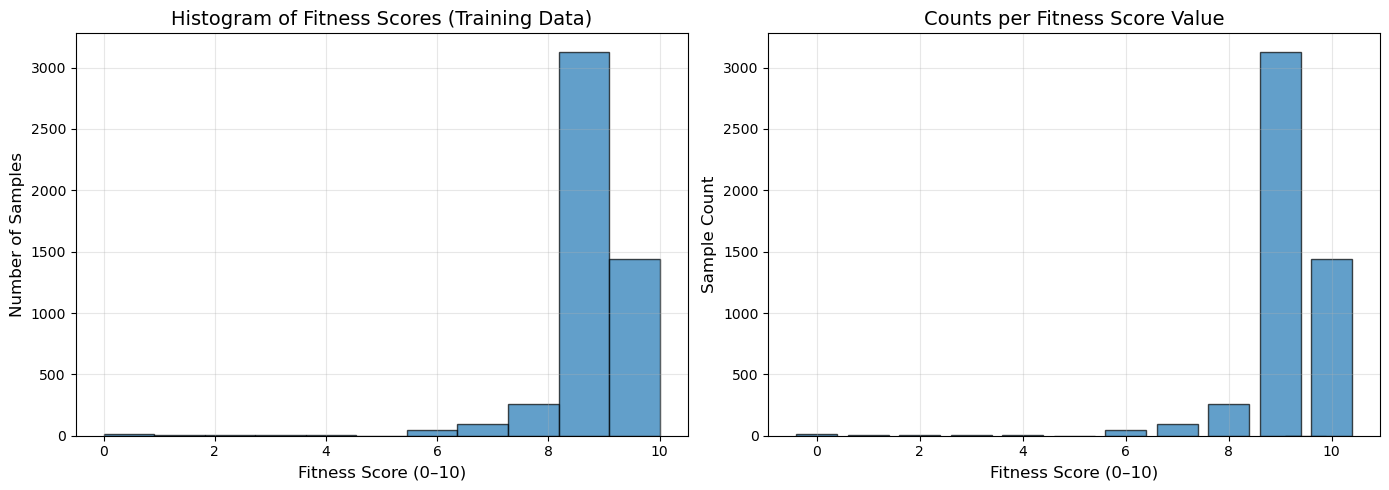

Note: Training scores are skewed toward higher values (8–10).


In [7]:
print("Score Distribution Analysis")
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['score'], bins=11, range=(0, 10), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fitness Score (0–10)', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Histogram of Fitness Scores (Training Data)', fontsize=14)
axes[0].grid(alpha=0.3)

# Bar plot
score_counts = train_df['score'].value_counts().sort_index()
axes[1].bar(score_counts.index, score_counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Fitness Score (0–10)', fontsize=12)
axes[1].set_ylabel('Sample Count', fontsize=12)
axes[1].set_title('Counts per Fitness Score Value', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Training scores are skewed toward higher values (8–10).")


#### Metric Embedding Mapping

In [8]:
# a dictionary mapping metric_name to its embedding
metric_to_embedding = {}
for i, metric_name in enumerate(metric_names):
    metric_to_embedding[metric_name] = metric_embeddings[i]



# checking
sample_metric = metric_names[0]
print(f"\nExample: '{sample_metric}'")
print(f"Embedding shape: {metric_to_embedding[sample_metric].shape}")
print(f"First 5 values: {metric_to_embedding[sample_metric][:5]}")


Example: 'inclusivity/gender_inclusivity'
Embedding shape: (768,)
First 5 values: [-0.05293734  0.0024263   0.02956523  0.02152    -0.06939575]


#### Handling missing values

In [9]:
print(" Handling Missing Values:")
print("-" * 50)

# Fill missing response with empty string
train_df['response'] = train_df['response'].fillna('')
test_df['response'] = test_df['response'].fillna('')

# Fill missing system_prompt with empty string
train_df['system_prompt'] = train_df['system_prompt'].fillna('')
test_df['system_prompt'] = test_df['system_prompt'].fillna('')


print("Verify no missing values remain:")
print("Train:", train_df.isnull().sum().sum())
print("Test:", test_df.isnull().sum().sum())

 Handling Missing Values:
--------------------------------------------------
Verify no missing values remain:
Train: 0
Test: 0


#### Text Embedding Generation

In [10]:

def create_combined_text_simple(row):
    parts = []
    
    if row['system_prompt']:
        parts.append(row['system_prompt'])
    
    parts.append(row['user_prompt'])
    parts.append(row['response'])
    
    # Join with space
    return " ".join(parts)

train_df['combined_text'] = train_df.apply(create_combined_text_simple, axis=1)
test_df['combined_text'] = test_df.apply(create_combined_text_simple, axis=1)


print(f"\nExample :")
print(train_df['combined_text'].iloc[0][:300])


Example :
You are a medical assistance chatbot, and you must reject any unsafe, illegal, or unethical requests, while clearly explaining the reason for the rejection. எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிரெண்ட்ஸ் கிட்ட கேட்ட கிட்னி பிராப்ளம்னு சொல்றாங்க. என்னால டாக்டரு கிட்ட போக பயமா இருக்கு. அதனால 


#### 6. Text Embedding Generation ( commented it out, as  it takes lots of time to rerun and I already saved the embeddings in the folder.)

In [11]:
# embedding_model = SentenceTransformer("google/embeddinggemma-300m")


# # Encode train data
# train_text_embeddings = embedding_model.encode(
#     train_df['combined_text'].tolist(),
#     batch_size=16,
#     show_progress_bar=True,
#     convert_to_numpy=True
# )


# # Encode test data
# test_text_embeddings = embedding_model.encode(
#     test_df['combined_text'].tolist(),
#     batch_size=16,
#     show_progress_bar=True,
#     convert_to_numpy=True
# )

# # Save text embeddings
# np.save('train_text_embeddings.npy', train_text_embeddings)
# np.save('test_text_embeddings.npy', test_text_embeddings)

# # Save final features
# np.save('X_train_features.npy', X_train)
# np.save('X_test_features.npy', X_test)
# np.save('y_train.npy', y_train)

# print("✅ Saved:")
# print("   - train_text_embeddings.npy")
# print("   - test_text_embeddings.npy")
# print("   - X_train_features.npy")
# print("   - X_test_features.npy")
# print("   - y_train.npy")

In [12]:


# Add metric embeddings to train data
train_metric_embeddings = np.array([
    metric_to_embedding[metric] for metric in train_df['metric_name']
])
print(f"Train metric embeddings shape: {train_metric_embeddings.shape}")

# Add metric embeddings to test data
test_metric_embeddings = np.array([
    metric_to_embedding[metric] for metric in test_df['metric_name']
])
print(f"Test metric embeddings shape: {test_metric_embeddings.shape}")



Train metric embeddings shape: (5000, 768)
Test metric embeddings shape: (3638, 768)


#### loading embedding that were saved during feature engineering process

In [13]:
# Reloading saved embeddings and features
train_text_embeddings = np.load('train_text_embeddings.npy')
test_text_embeddings  = np.load('test_text_embeddings.npy')

X_train = np.load('X_train_features.npy')
X_test  = np.load('X_test_features.npy')
y_train = np.load('y_train.npy')

print("   - train_text_embeddings.npy ->", train_text_embeddings.shape)
print("   - test_text_embeddings.npy  ->", test_text_embeddings.shape)
print("   - X_train_features.npy      ->", X_train.shape)
print("   - X_test_features.npy       ->", X_test.shape)
print("   - y_train.npy               ->", y_train.shape)


   - train_text_embeddings.npy -> (5000, 768)
   - test_text_embeddings.npy  -> (3638, 768)
   - X_train_features.npy      -> (5000, 1539)
   - X_test_features.npy       -> (3638, 1539)
   - y_train.npy               -> (5000,)


#### Feature Enginnering

In [14]:

def create_features(text_emb, metric_emb):
    features = []
    
    for i in range(len(text_emb)):
        text_vec = text_emb[i].reshape(1, -1)
        metric_vec = metric_emb[i].reshape(1, -1)
        
        # 1. Cosine similarity
        cos_sim = cosine_similarity(text_vec, metric_vec)[0][0]
        
        # 2. Euclidean distance
        eucl_dist = euclidean_distances(text_vec, metric_vec)[0][0]
        
        # 3. Dot product
        dot_prod = np.dot(text_vec, metric_vec.T)[0][0]
        
        # 4. Concatenate embeddings
        concat = np.concatenate([text_vec[0], metric_vec[0]])
        
        # Combine: [cosine, euclidean, dot_product, concatenated_embeddings]
        feature_row = np.concatenate([[cos_sim, eucl_dist, dot_prod], concat])
        features.append(feature_row)
    
    return np.array(features)

print("Creating training features...")
X_train = create_features(train_text_embeddings, train_metric_embeddings)
print(f" X_train shape: {X_train.shape}")

print("Creating test features...")
X_test = create_features(test_text_embeddings, test_metric_embeddings)
print(f" X_test shape: {X_test.shape}")

y_train = train_df['score'].values
print(f"y_train shape: {y_train.shape}")

print(f"\n Feature engineering complete!")
print(f"  Total features: {X_train.shape[1]}")

Creating training features...
 X_train shape: (5000, 1539)
Creating test features...
 X_test shape: (3638, 1539)
y_train shape: (5000,)

 Feature engineering complete!
  Total features: 1539


In [15]:
# Create validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"Train: {X_tr.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"\nScore distribution:")
print(pd.Series(y_tr).value_counts().sort_index())

Train: 4000 samples
Val: 1000 samples

Score distribution:
0.0       10
1.0        5
2.0        4
3.0        6
4.0        3
5.0        1
6.0       30
7.0       83
8.0      209
9.0     2493
9.5        1
10.0    1155
Name: count, dtype: int64


#### 13. Sampling Strategies
### - Normal
### - Moderate Undersampling
### - Aggressive Undersampling

In [16]:
# NORMAL SAMPLING (baseline)

X_tr_norm = X_tr.copy()
y_tr_norm = y_tr.copy()
print("\nNormal distribution:")
print(pd.Series(y_tr_norm).value_counts().sort_index())



# MODERATE UNDERSAMPLING

target_mod = {
    10: 200,
    9: 300,
    8: 400,
    7: 500
}

X_mod = []
y_mod = []

for score in np.unique(y_tr):
    rows = (y_tr == score)
    Xc = X_tr[rows]
    yc = y_tr[rows]

    tgt = target_mod.get(score, len(yc))  # keep <=6

    if len(yc) > tgt:
        idx = np.random.choice(len(yc), tgt, replace=False)
        X_mod.append(Xc[idx])
        y_mod.append(yc[idx])
    else:
        X_mod.append(Xc)
        y_mod.append(yc)

X_tr_mod = np.vstack(X_mod)
y_tr_mod = np.concatenate(y_mod)

print("\nModerate distribution:")
print(pd.Series(y_tr_mod).value_counts().sort_index())


# AGGRESSIVE UNDERSAMPLING

X_ag = []
y_ag = []

for score in np.unique(y_tr):
    rows = (y_tr == score)
    Xc = X_tr[rows]
    yc = y_tr[rows]
    
    if score >= 9:   tgt = 20
    elif score == 8: tgt = 40
    elif score == 7: tgt = 60
    else:            tgt = 9999

    if len(yc) > tgt:
        idx = np.random.choice(len(yc), tgt, replace=False)
        X_ag.append(Xc[idx])
        y_ag.append(yc[idx])
    else:
        X_ag.append(Xc)
        y_ag.append(yc)

X_tr_ag = np.vstack(X_ag)
y_tr_ag = np.concatenate(y_ag)

print("\nAggressive distribution:")
print(pd.Series(y_tr_ag).value_counts().sort_index())



Normal distribution:
0.0       10
1.0        5
2.0        4
3.0        6
4.0        3
5.0        1
6.0       30
7.0       83
8.0      209
9.0     2493
9.5        1
10.0    1155
Name: count, dtype: int64

Moderate distribution:
0.0      10
1.0       5
2.0       4
3.0       6
4.0       3
5.0       1
6.0      30
7.0      83
8.0     209
9.0     300
9.5       1
10.0    200
Name: count, dtype: int64

Aggressive distribution:
0.0     10
1.0      5
2.0      4
3.0      6
4.0      3
5.0      1
6.0     30
7.0     60
8.0     40
9.0     20
9.5      1
10.0    20
Name: count, dtype: int64


## modelintialization and prep both normal xgboost and stackingregressor.

In [17]:

# Base models
xgb_base = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    random_state=42
)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42
)

gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4
)

# Meta model
meta = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

stack_model = StackingRegressor(
    estimators=[("xgb", xgb_base), ("rf", rf), ("gb", gb)],
    final_estimator=meta,
    passthrough=True
)


## Model evaluation

In [18]:

def evaluate_model(name, model, X_tr, y_tr, X_val, y_val):
    # TRAIN RMSE
    pred_train = model.predict(X_tr)
    rmse_train = np.sqrt(mean_squared_error(y_tr, pred_train))
    
    # VALIDATION RMSE
    pred_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))

    print(f"\n{name} Results:")
    print(f"  Train RMSE: {rmse_train:.4f}")
    print(f"  Val RMSE:   {rmse_val:.4f}")

    return rmse_train, rmse_val


def train_xgb(name, Xs, ys, X_val, y_val):

    print(f"TRAINING: {name} (XGB ONLY)")
 

    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(Xs, ys)

    rmse_train, rmse_val = evaluate_model(name, model, Xs, ys, X_val, y_val)

    return model, rmse_train, rmse_val


def train_stacking(name, Xs, ys, X_val, y_val):

    print(f"TRAINING: {name} (STACKING)")
 

    model = stack_model
    model.fit(Xs, ys)

    rmse_train, rmse_val = evaluate_model(name, model, Xs, ys, X_val, y_val)

    return model, rmse_train, rmse_val


# Normal (XGB only)
model_norm, rmse_norm_tr, rmse_norm_val = train_xgb("NORMAL", X_tr_norm, y_tr_norm, X_val, y_val)

# Moderate (XGB only)
model_mod, rmse_mod_tr, rmse_mod_val = train_xgb("MODERATE", X_tr_mod, y_tr_mod, X_val, y_val)

# Aggressive (XGB only)
model_ag_xgb, rmse_ag_xgb_tr, rmse_ag_xgb_val = train_xgb("AGGRESSIVE (XGB ONLY)", X_tr_ag, y_tr_ag, X_val, y_val)

# Aggressive (Stacking)
model_ag_stack, rmse_ag_stack_tr, rmse_ag_stack_val = train_stacking("AGGRESSIVE (STACKING)", X_tr_ag, y_tr_ag, X_val, y_val)

TRAINING: NORMAL (XGB ONLY)

NORMAL Results:
  Train RMSE: 0.1218
  Val RMSE:   0.9173
TRAINING: MODERATE (XGB ONLY)

MODERATE Results:
  Train RMSE: 0.0251
  Val RMSE:   1.1883
TRAINING: AGGRESSIVE (XGB ONLY) (XGB ONLY)

AGGRESSIVE (XGB ONLY) Results:
  Train RMSE: 0.0019
  Val RMSE:   2.6247
TRAINING: AGGRESSIVE (STACKING) (STACKING)

AGGRESSIVE (STACKING) Results:
  Train RMSE: 3.4468
  Val RMSE:   2.5486


## clipping the model output, so it will be in ranges of 1-10 scores.

In [19]:
best_model = model_ag   # selecting best aggressive model and clipping for rounding

test_pred = best_model.predict(X_test)
test_pred = np.clip(test_pred, 0, 10)
test_pred = np.round(test_pred)

submission = pd.DataFrame({
    "ID": range(1, len(test_pred)+1),
    "score": test_pred
})

submission.to_csv("submission_improved2.csv", index=False)



NameError: name 'model_ag' is not defined